# Evaluation pendulum

In [1]:
import os
import yaml
import json

import torch

from matplotlib import pyplot as plt
import numpy as np

from src.nnets import MLPConditionalGenerator, get_mlp_discriminator
from src.nnets import NeuralPendulum
from src.forward_models.pendulum.pendulum_model import SimplePendulum, PendulumSolver

from src.data_loader.config_data_loader import (
    get_x_params_sampler,
)

from src.data_loader.config_data_loader import SimulatorDataset, SimulationSampler
from src.nnets.utils import load_model


from src.metrics.mmd import MMDLoss, RBF, estimate_mmd_bandwidth
from src.data_loader.data_loader import get_data_loader


In [2]:
# Multidimensional Mean square root error
def rmse(y_true, y_pred):
    return torch.sqrt(torch.mean((torch.tensor(y_true) - torch.tensor(y_pred))**2, dim=1))

# Multidimensional Relative Mean square root error
def relative_rmse(y_true, y_pred):
    return torch.sqrt(torch.mean(((torch.tensor(y_true) - torch.tensor(y_pred)) / torch.tensor(y_true))**2, dim=1))

In [3]:
task_name = "pendulum"
test_exp_name = "6a17c4c8d5fdce009fe548e5ac173380"
dataset_file_path = f"../../../datasets/forward_models/pendulum/one_to_one/testing/data_{test_exp_name}"
method="rk4"

device = "cpu"#torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_dataset = SimulatorDataset(
    name_dataset=task_name,
    data_file_path=dataset_file_path,
    testing_set=True,
    device=device,
)
test_loader = get_data_loader(test_dataset, batch_size=1024)

In [4]:
test_samples = test_loader.sample()
test_params = test_samples["params"]
test_sims = test_samples["x"]
test_init_conds = test_samples["init_conds"]
print(test_params.shape)
print(test_sims.shape)

torch.Size([100, 1, 4])
torch.Size([100, 1, 50])


In [5]:
# Retrieve the parameters and initial conditions for the incomplete model
param_dim = 1
noisy_samples = test_params.shape[
    1
]  # number of stochastic samples

print(f"Test number of noisy samples per parameter: {noisy_samples}" )
X_params = test_params[:, :, :param_dim]
X_params = X_params.reshape(-1, param_dim)
X_params = X_params[::noisy_samples]
X_init_conds = test_init_conds.reshape(
    -1, test_init_conds.shape[-1]
)
X_init_conds = X_init_conds[::noisy_samples]
phys_model = PendulumSolver(
    len_episode=test_dataset.conf_data["all_args"]["len_episode"],
    dt=test_dataset.conf_data["all_args"]["dt"],
    method=method)
res_sims = phys_model(init_conds=X_init_conds, params=X_params)
X_sims = res_sims["x"]

# Print shapes
print(X_params.shape)
print(X_init_conds.shape)
print(X_sims.shape)

t = torch.linspace(0.0, phys_model.dt * (test_sims.shape[-1] - 1), test_sims.shape[-1])
save_path = f"../../../outputs/figures/pendulum/{test_exp_name}"


Test number of noisy samples per parameter: 1
torch.Size([100, 1])
torch.Size([100, 2])
torch.Size([100, 50])


In [6]:
# Load OT-GB model
path_model_file = f"../../../outputs/best_models/pendulum/one-mode/checkpoints/ot-gb/KlKQ/model_2705011fa542ef0da55f8b9a4272e214_exp_b0af176f7b1d439550e605188cbc1138_f097c1d3009fda1b72a3c6595f5c9110_salt_KlKQ_best.pt"

ot_model, parent_dir, config, dic_chkpt = load_model(
            path_model_file=path_model_file, device=device
        )
dic_chkpt["epoch"]

Loading model from ../../../outputs/best_models/pendulum/one-mode/checkpoints/ot-gb/KlKQ/model_2705011fa542ef0da55f8b9a4272e214_exp_b0af176f7b1d439550e605188cbc1138_f097c1d3009fda1b72a3c6595f5c9110_salt_KlKQ_config.yaml
NeuralPendulum(
  (nnet): MLPConditionalGenerator(
    (x_blocks): ModuleList(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
    (context_blocks): ModuleList(
      (0-1): 2 x Linear(in_features=1, out_features=64, bias=True)
    )
  )
  (physics_model): SimplePendulum()
)
Loading model from ../../../outputs/best_models/pendulum/one-mode/checkpoints/ot-gb/KlKQ/model_2705011fa542ef0da55f8b9a4272e214_exp_b0af176f7b1d439550e605188cbc1138_f097c1d3009fda1b72a3c6595f5c9110_salt_KlKQ_best.pt


2605

In [7]:
# Load WGANS-GB model
path_model_file = f"../../../outputs/best_models/pendulum/one-mode/checkpoints/wgans-gb/yFHN/model_639400208cd5d9ca4a9bc391a29ea8e5_exp_b0af176f7b1d439550e605188cbc1138_f097c1d3009fda1b72a3c6595f5c9110_salt_yFHN_best.pt"

wgans_model, parent_dir, config, dic_chkpt = load_model(
            path_model_file=path_model_file, device=device
        )
print(dic_chkpt["epoch"])

Loading model from ../../../outputs/best_models/pendulum/one-mode/checkpoints/wgans-gb/yFHN/model_639400208cd5d9ca4a9bc391a29ea8e5_exp_b0af176f7b1d439550e605188cbc1138_f097c1d3009fda1b72a3c6595f5c9110_salt_yFHN_config.yaml
NeuralPendulum(
  (nnet): MLPConditionalGenerator(
    (x_blocks): ModuleList(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
    (context_blocks): ModuleList(
      (0-1): 2 x Linear(in_features=1, out_features=64, bias=True)
    )
  )
  (physics_model): SimplePendulum()
)
Loading model from ../../../outputs/best_models/pendulum/one-mode/checkpoints/wgans-gb/yFHN/model_639400208cd5d9ca4a9bc391a29ea8e5_exp_b0af176f7b1d439550e605188cbc1138_f097c1d3009fda1b72a3c6595f5c9110_salt_yFHN_best.pt
800


In [8]:
# OT-BB model
#path_model_file = f"../../../outputs/best_models/pendulum/one-mode/checkpoints/ot-bb/E3Wu/model_b85f23c42f6ceba898213f15b67d9004_exp_b0af176f7b1d439550e605188cbc1138_f097c1d3009fda1b72a3c6595f5c9110_salt_E3Wu_best.pt"
#ot_bb_model, parent_dir, config, dic_chkpt = load_model(
#            path_model_file=path_model_file, device=device
#        )

In [9]:
ot_model.ode_solver="dopri8"

In [10]:
with torch.no_grad():
    ot_pred = ot_model.predict(X_sims, context=X_params)
    wgans_pred = wgans_model.predict(X_sims, context=X_params)

/home/jeet/miniconda3/envs/ot-miss/lib/python3.9/site-packages/torchdiffeq/_impl/misc.py:11: UserWarning: Dopri8Solver: Unexpected arguments {'step_size': 0.1}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


In [11]:
test_params = test_params.view(test_params.shape[0], -1)
test_sims = test_sims.view(test_sims.shape[0], -1)

In [12]:
with torch.no_grad():
    y_ode_sims = phys_model(params=test_params, init_conds=X_init_conds)
dt_fr = phys_model.dt_friction
torch.isclose(y_ode_sims["x"], test_sims).all()

tensor(True)

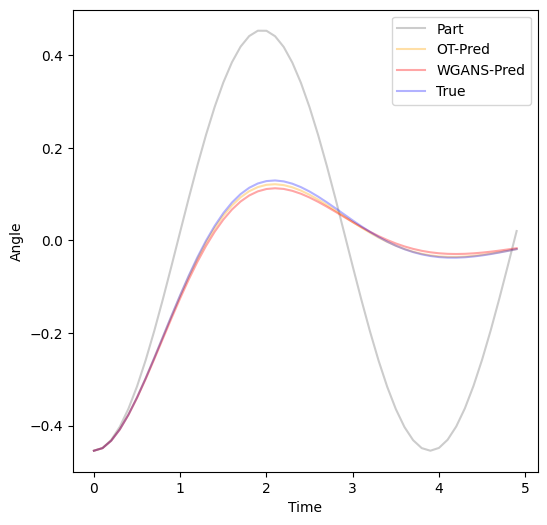

In [13]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))
idx= torch.randint(0, test_sims.shape[0], (1,)).item()

t = torch.linspace(0.0, phys_model.dt * (test_sims.shape[-1] - 1), test_sims.shape[-1])
axes.plot(t, X_sims[idx].tolist(), color="gray", label="Part", alpha=0.4)
y_hat = ot_pred.reshape(-1, 50)
y_hat_w = wgans_pred.reshape(-1, 50)
y = test_sims[idx].flatten()
axes.plot(t, y_hat[idx].tolist(), color="orange", label="OT-Pred", alpha=0.35)
axes.plot(t, y_hat_w[idx].tolist(), color="red", label="WGANS-Pred", alpha=0.35)
axes.plot(t, y.tolist(), color="blue", label="True", alpha=0.3)

axes.set_xlabel("Time")
axes.set_ylabel("Angle")
axes.legend()

## Least source cost?
Has the OT a smaller cost than WGANS? 

In [14]:
ot_cost = torch.linalg.norm(ot_pred - X_sims, ord=2, dim=-1).mean()
w_cost = torch.linalg.norm(wgans_pred - X_sims, ord=2, dim=-1).mean()
print(f"Minimal cost from source c(x, y):\n\tOT {ot_cost} \n\tWGAN {w_cost}")

Minimal cost from source c(x, y):
	OT 3.1788113117218018 
	WGAN 3.208376169204712


## ODE gradient evaluation

### Trajectory error

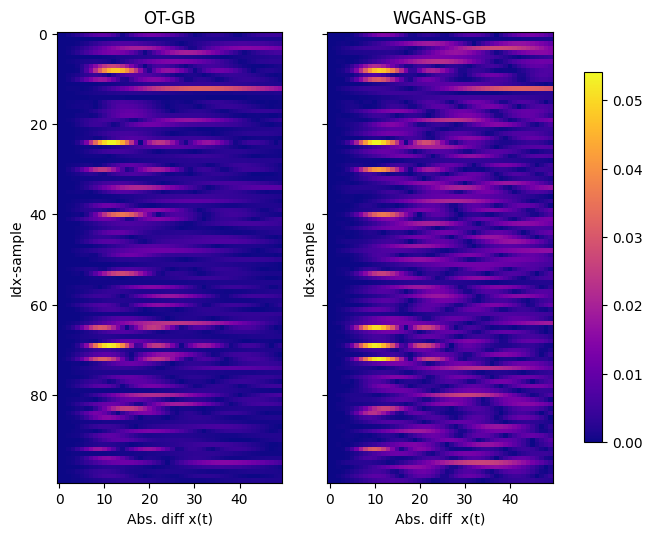

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(8, 8), sharey=True)
kwargs = {'cmap':'plasma', 'interpolation':'none'}
pos = axes[0].imshow(torch.abs(test_sims - ot_pred), **kwargs)
axes[0].set_title("OT-GB")
#fig.colorbar(pos, ax=axes[0], location='right')
pos = axes[1].imshow(torch.abs(test_sims - wgans_pred), **kwargs)
axes[1].set_title("WGANS-GB")

axes[0].set_xlabel(r"Abs. diff x(t)")
axes[0].set_ylabel("Idx-sample")
axes[1].set_xlabel(r"Abs. diff  x(t)")
axes[1].set_ylabel("Idx-sample")
fig.colorbar(pos, ax=axes[:], location='right', shrink=0.6)
plt.show()

## In-Solver error

In [16]:
dt_fr = torch.stack(dt_fr, dim=0)
dt_fr=dt_fr.permute(1, 2, 0)
print(dt_fr.shape)
ot_dt_fr = torch.stack(ot_model.nnet_f_evals, dim=0)
ot_dt_fr=ot_dt_fr.permute(1, 2, 0)
print(ot_dt_fr.shape)
wgans_dt_fr = torch.stack(wgans_model.nnet_f_evals, dim=0)
wgans_dt_fr=wgans_dt_fr.permute(1, 2, 0)
print(wgans_dt_fr.shape)

torch.Size([100, 2, 196])
torch.Size([100, 2, 1796])
torch.Size([100, 2, 196])


OT interpolation

In [17]:
from scipy.interpolate import interp1d
print(ot_dt_fr[0, 1].shape)
ot_dt_interp = np.zeros((dt_fr.shape[0], dt_fr.shape[-1])) * np.nan

for i in range(dt_fr.shape[0]):
    ot_f_inter = interp1d(ot_dt_fr[i, 1], ot_dt_fr[i, 0], kind='linear')
    ot_dt_interp[i] = ot_f_inter(dt_fr[i, 1])

ot_dt_interp = torch.tensor(ot_dt_interp, dtype=torch.float32)
ot_dt_interp.shape


torch.Size([1796])


torch.Size([100, 196])

In [18]:
gt_f_norm = torch.linalg.norm(dt_fr[:, 0], ord=2, dim=1)
ot_f_norm = torch.linalg.norm(ot_dt_interp, ord=2, dim=1)
wgans_f_norm = torch.linalg.norm(wgans_dt_fr[:, 0], ord=2, dim=1)
print(f" avg(norm(f(t))) \n Reference: ", torch.mean(gt_f_norm), f"\n OT: ", torch.mean(ot_f_norm),f"\n WGANS: ", torch.mean(wgans_f_norm))

 avg(norm(f(t))) 
 Reference:  tensor(8.2756) 
 OT:  tensor(8.2341) 
 WGANS:  tensor(8.3134)


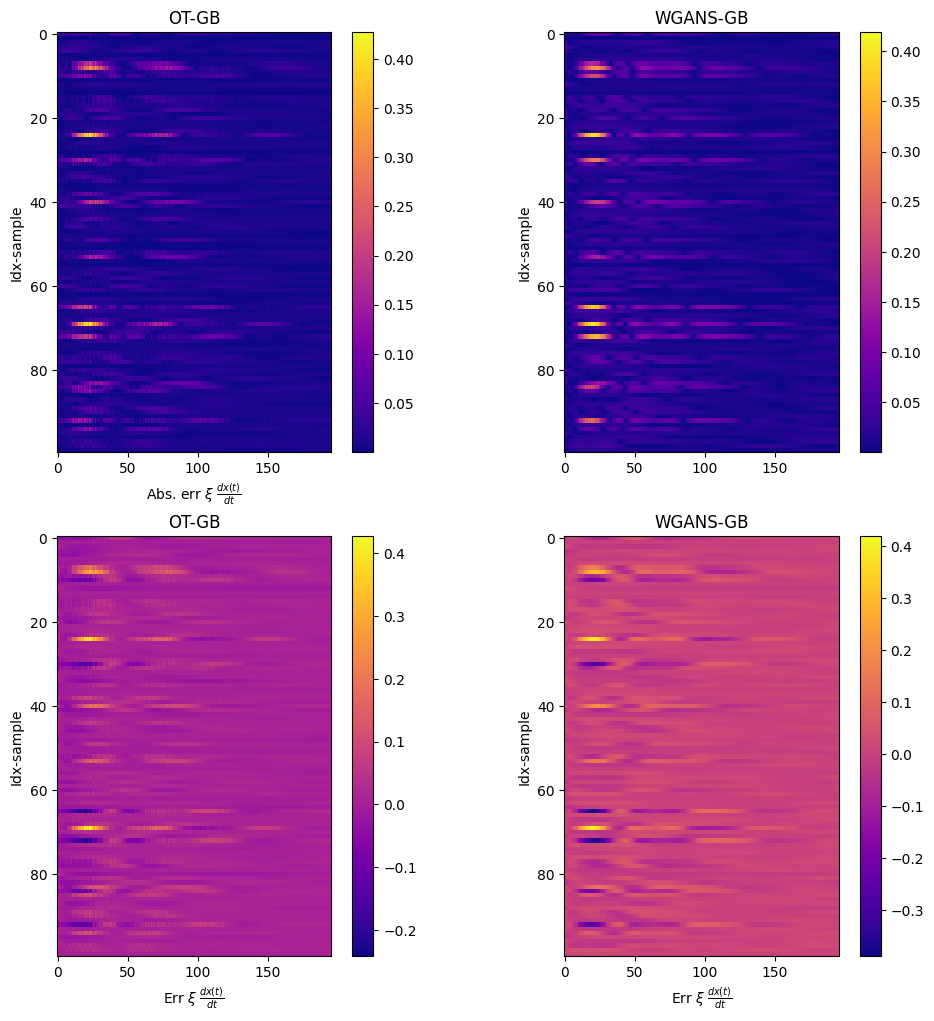

In [19]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
kwargs = {'aspect':3.0, 'cmap':'plasma', 'interpolation':'none'}
# Absolute error
pos = axes[0, 0].imshow(torch.abs(-dt_fr[:, 0] - ot_dt_interp), **kwargs,)
fig.colorbar(pos, ax=axes[0, 0], location='right')
axes[0, 0].set_title("OT-GB")
pos = axes[0, 1].imshow(torch.abs(-dt_fr[:, 0] - wgans_dt_fr[:, 0]), **kwargs)
fig.colorbar(pos, ax=axes[0, 1], location='right')
axes[0, 1].set_title("WGANS-GB")
axes[0,0].set_ylabel("Idx-sample")
axes[0,0].set_xlabel(r"Abs. err $\xi \; \frac{dx(t)}{dt}$")
axes[0,1].set_ylabel("Idx-sample")
axes[0,0].set_xlabel(r"Abs. err $\xi \; \frac{dx(t)}{dt}$")

# Error
pos = axes[1, 0].imshow(-dt_fr[:, 0] - ot_dt_interp, **kwargs,)
fig.colorbar(pos, ax=axes[1, 0], location='right')
axes[1,0].set_title("OT-GB")
axes[1,0].set_xlabel(r"Err $\xi \; \frac{dx(t)}{dt}$")
axes[1,0].set_ylabel("Idx-sample")

pos = axes[1, 1].imshow((-dt_fr[:, 0] - wgans_dt_fr[:, 0]), **kwargs)
axes[1,1].set_title("WGANS-GB")
axes[1,1].set_xlabel(r"Err $\xi \; \frac{dx(t)}{dt}$")
axes[1,1].set_ylabel("Idx-sample")
fig.colorbar(pos, ax=axes[1, 1], location='right')
plt.show()

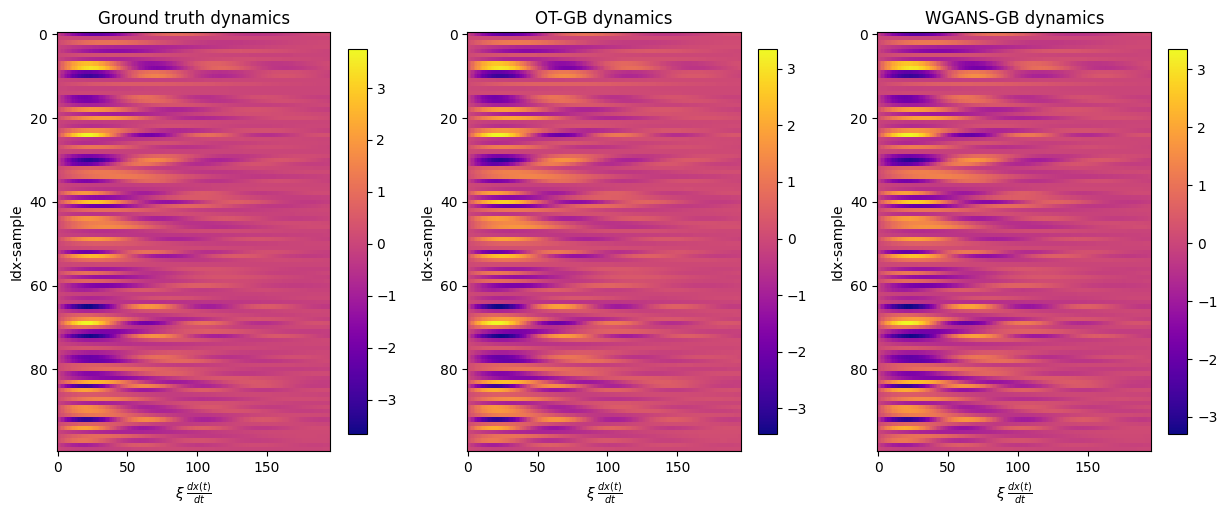

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(15, 10))
kwargs = {'aspect':3.0, 'cmap':'plasma', 'interpolation':'none'}

pos = axes[0].imshow(-dt_fr[:, 0], **kwargs,)
fig.colorbar(pos, ax=axes[0], location='right', shrink=0.5)
axes[0].set_title("Ground truth dynamics")
pos = axes[1].imshow(ot_dt_interp, **kwargs)
fig.colorbar(pos, ax=axes[1], location='right', shrink=0.5)
axes[1].set_title("OT-GB dynamics")

pos = axes[2].imshow(wgans_dt_fr[:, 0], **kwargs)
fig.colorbar(pos, ax=axes[2], location='right', shrink=0.5)
axes[2].set_title("WGANS-GB dynamics")

axes[0].set_ylabel("Idx-sample")
axes[0].set_xlabel(r"$\xi \; \frac{dx(t)}{dt}$")
axes[1].set_ylabel("Idx-sample")
axes[1].set_xlabel(r"$\xi \; \frac{dx(t)}{dt}$")

axes[2].set_ylabel("Idx-sample")
axes[2].set_xlabel(r"$\xi \; \frac{dx(t)}{dt}$")
plt.show()

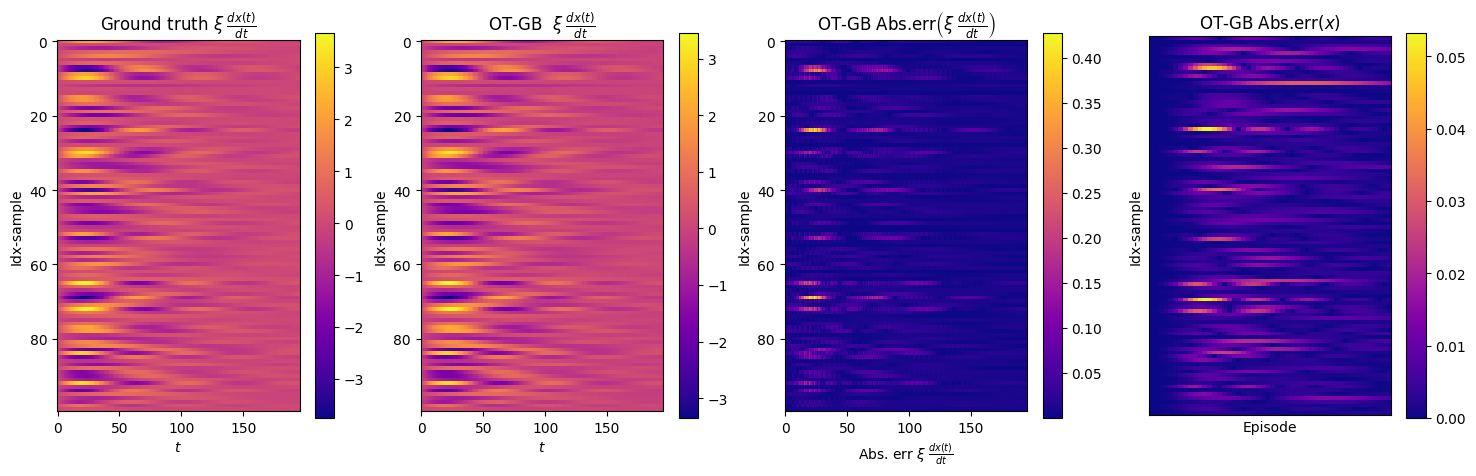

In [21]:
fig, axes = plt.subplots(1, 4, figsize=(18, 10))
kwargs = {'aspect':3.0, 'cmap':'plasma', 'interpolation':'none'}

pos = axes[0].imshow(dt_fr[:, 0], **kwargs,)
fig.colorbar(pos, ax=axes[0], location='right', shrink=0.5)
axes[0].set_title(r"Ground truth $\xi \; \frac{dx(t)}{dt}$")
pos = axes[1].imshow(-ot_dt_interp, **kwargs)
fig.colorbar(pos, ax=axes[1], location='right', shrink=0.5)
axes[1].set_title(r"OT-GB  $\xi \; \frac{dx(t)}{dt}$")

kwargs = {'aspect':3.0, 'cmap':'plasma', 'interpolation':'none'}
pos = axes[2].imshow(torch.abs(-dt_fr[:, 0] - ot_dt_interp), **kwargs,)
axes[2].set_title(r"OT-GB Abs.err$\left(\xi \; \frac{dx(t)}{dt}\right)$")
fig.colorbar(pos, ax=axes[2], location='right',  shrink=0.5)


kwargs = {'aspect':0.78, 'cmap':'plasma', 'interpolation':'none'}
pos = axes[3].imshow(torch.abs(test_sims - ot_pred), **kwargs)
fig.colorbar(pos, ax=axes[3], location='right', shrink=0.5)
axes[3].set_title(r"OT-GB Abs.err$(x)$")

axes[0].set_ylabel("Idx-sample")
axes[0].set_xlabel(r"$t$")
axes[1].set_ylabel("Idx-sample")
axes[1].set_xlabel(r"$t$")

axes[2].set_xlabel(r"Abs. err $\xi \; \frac{dx(t)}{dt}$")
axes[2].set_ylabel("Idx-sample")
axes[3].set_xlabel(r"Episode")
axes[3].set_ylabel("Idx-sample")
save_path = f"../../../outputs/figures/pendulum/{test_exp_name}"
os.makedirs(save_path, exist_ok=True)

plt.margins(0,0)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig(f"{save_path}/ot_gb_dynamics.png", bbox_inches = 'tight', pad_inches = 0)
plt.show()

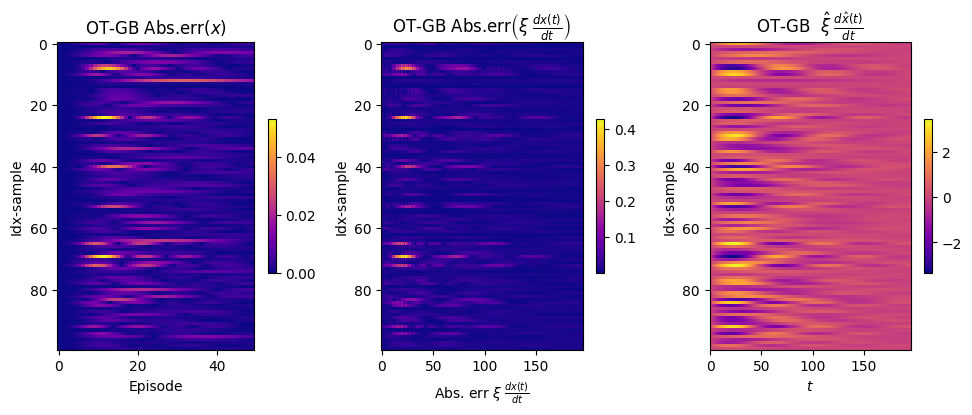

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
kwargs = {'aspect':0.78, 'cmap':'plasma', 'interpolation':'none'}
pos = axes[0].imshow(torch.abs(test_sims - ot_pred), **kwargs)
fig.colorbar(pos, ax=axes[0], location='right', shrink=0.5)
axes[0].set_title(r"OT-GB Abs.err$(x)$")

kwargs = {'aspect':3.0, 'cmap':'plasma', 'interpolation':'none'}
pos = axes[1].imshow(torch.abs(-dt_fr[:, 0] - ot_dt_interp), **kwargs,)
axes[1].set_title(r"OT-GB Abs.err$\left(\xi \; \frac{dx(t)}{dt}\right)$")
fig.colorbar(pos, ax=axes[1], location='right',  shrink=0.5)

kwargs = {'aspect':3.0, 'cmap':'plasma', 'interpolation':'none'}
pos = axes[2].imshow(-ot_dt_interp, **kwargs)
fig.colorbar(pos, ax=axes[2], location='right', shrink=0.5)
axes[2].set_title(r"OT-GB  $\hat{\xi} \; \frac{d\hat{x}(t)}{dt}$")

axes[1].set_xlabel(r"Abs. err $\xi \; \frac{dx(t)}{dt}$")
axes[1].set_ylabel("Idx-sample")
axes[0].set_xlabel(r"Episode")
axes[0].set_ylabel("Idx-sample")

axes[2].set_ylabel("Idx-sample")
axes[2].set_xlabel(r"$t$")

save_path = f"../../../outputs/figures/pendulum/{test_exp_name}"
os.makedirs(save_path, exist_ok=True)

plt.margins(0,0)
#plt.gca().xaxis.set_major_locator(plt.NullLocator())
#plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.savefig(f"{save_path}/ot_gb_dynamics.png", bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [23]:
# Dt friction errory
print("Friction error:")
print(f"\t OT", torch.mean(torch.linalg.norm(torch.abs(-dt_fr[:, 0] - (ot_dt_interp)), dim=-1), dim=0))
print(f"\t WGANS", torch.mean(torch.linalg.norm(torch.abs(-dt_fr[:, 0] - wgans_dt_fr[:, 0]), dim=-1), dim=0))

# Whole trajectory error
print("Whole trajectory error:")

print(f"\t OT", torch.mean(torch.linalg.norm(torch.abs(y_ode_sims["x"] - ot_pred), dim=-1), dim=0))
print(f"\t WGANS", torch.mean(torch.linalg.norm(torch.abs(y_ode_sims["x"]- wgans_pred), dim=-1), dim=0))

Friction error:
	 OT tensor(0.2984)
	 WGANS tensor(0.3720)
Whole trajectory error:
	 OT tensor(0.0393)
	 WGANS tensor(0.0600)


## Cumulative dt error

In [24]:
print(torch.mean(torch.sum(torch.abs(-dt_fr[:, 0] - ot_dt_interp), dim=-1), dim=0))
print(torch.mean(torch.sum(torch.abs(-dt_fr[:, 0] - wgans_dt_fr[:, 0]), dim=-1), dim=0))

tensor(3.1841)
tensor(4.0196)


## Black-box vs Grey-box models

In [ ]:
## Uniform pendulum sampler and 2 mode sampler 
from src.sampler.distributions import BoxUniformSampler, Bernoulli

# uniform sampler
param_1_lb = 0.2
param_1_ub = 1.5
y_params_sampler = BoxUniformSampler(torch.tensor([param_1_lb], device=device), torch.tensor([param_1_ub], device=device), device=device)
y_params_m = y_params_sampler.sample((X_params.shape[0], 10))
y_params_m = y_params_m.reshape(X_params.shape[0], 10, 1)
y_params_m = torch.concat([X_params.unsqueeze(1).repeat(1,10,1), y_params_m], dim=-1)
print(y_params_m.shape)
X_init_conds_m = X_init_conds.unsqueeze(1).repeat(1, 10, 1)
print(X_init_conds_m.shape)

y_param_b = Bernoulli(0.5, head=torch.tensor([1.5]), tail=torch.tensor([0.6]), device=device)
y_params_b = y_param_b.sample((X_params.shape[0], 6))
y_params_b = y_params_b.reshape(X_params.shape[0], 6, 1)
y_params_b = torch.concat([X_params.unsqueeze(1).repeat(1,6,1), y_params_b], dim=-1)
X_init_conds_b = X_init_conds.unsqueeze(1).repeat(1, 6, 1)
print(y_params_b.shape)
print(X_init_conds_b.shape)

# Generate test samples
with torch.no_grad():
    y_sims_m = phys_model(init_conds=X_init_conds_m.flatten(start_dim=0, end_dim=1), params=y_params_m.flatten(start_dim=0, end_dim=1))
    y_sims_b = phys_model(init_conds=X_init_conds_b.flatten(start_dim=0, end_dim=1), params= y_params_b.flatten(start_dim=0, end_dim=1))

y_sims_m = y_sims_m["x"].reshape(-1, 10, 50)
y_sims_b = y_sims_b["x"].reshape(-1, 6, 50)


In [ ]:
# models for stochastic experiments

# OT - many modes
path_model_file = f"../../../outputs/best_models/pendulum/many-modes/joint/mmd/ot-gb/seed-13/b0af176f7b1d439550e605188cbc1138/kLYb_score_0.0076_epoch_-1/model_727c202c95c2cdb149a564d2cb1cde36_exp_b0af176f7b1d439550e605188cbc1138_0c4be06cb37e9cdb02c2f92076ff3bef_salt_kLYb_final.pt"
ot_gb_m_model, parent_dir, config, dic_chkpt = load_model(
            path_model_file=path_model_file, device=device
        )
# OT - 2 modes
path_model_file = f"../../../outputs/best_models/pendulum/two-modes/joint/c2st/ot-gb/seed-14/b0af176f7b1d439550e605188cbc1138/FAWo_score_0.6158_epoch_-1/model_51e8a05555103c32ccea11827821c914_exp_b0af176f7b1d439550e605188cbc1138_69da0017a32f79050413105f6952a038_salt_FAWo_best.pt"
ot_gb_2_model, parent_dir, config, dic_chkpt = load_model(
            path_model_file=path_model_file, device=device
        )

path_model_file = f"../../../outputs/best_models/pendulum/many-modes/joint/mmd/ot-bb/lstm/seed-13/b0af176f7b1d439550e605188cbc1138/yGuO_score_0.0274_epoch_-1/model_9410f427cc6f338ec0226babbc9175dc_exp_b0af176f7b1d439550e605188cbc1138_0c4be06cb37e9cdb02c2f92076ff3bef_salt_yGuO_final.pt"
ot_bb_m_model, parent_dir, config, dic_chkpt = load_model(
            path_model_file=path_model_file, device=device
        )
# OT - 2 modes
path_model_file = f"../../../outputs/best_models/pendulum/two-modes/marginal/mmd/ot-bb/lstm/seed-13/b0af176f7b1d439550e605188cbc1138/PdFn_score_0.0808_epoch_-1/model_429cb16a5395140c64f7b1efb001f742_exp_b0af176f7b1d439550e605188cbc1138_69da0017a32f79050413105f6952a038_salt_PdFn_best.pt"
ot_bb_2_model, parent_dir, config, dic_chkpt = load_model(
            path_model_file=path_model_file, device=device
        )

# WGAN - many modes
path_model_file = f"../../../outputs/best_models/pendulum/many-modes/joint/mmd/wgans-gb/seed-13/b0af176f7b1d439550e605188cbc1138/NahI_score_0.0188_epoch_-1/model_3fa343c157f47aeab0e36b10b7a29c87_exp_b0af176f7b1d439550e605188cbc1138_0c4be06cb37e9cdb02c2f92076ff3bef_salt_NahI_final.pt"
wgans_gb_m_model, parent_dir, config, dic_chkpt = load_model(
            path_model_file=path_model_file, device=device
        )

path_model_file = f"../../../outputs/best_models/pendulum/two-modes/joint/mmd/wgans-gb/seed-13/b0af176f7b1d439550e605188cbc1138/xowX_score_0.0227_epoch_-1/model_29ea4ddb9c9fa377f85deaf6b14c8009_exp_b0af176f7b1d439550e605188cbc1138_69da0017a32f79050413105f6952a038_salt_xowX_best.pt"
wgans_gb_2_model, parent_dir, config, dic_chkpt = load_model(
            path_model_file=path_model_file, device=device
        )

path_model_file = f"../../../outputs/best_models/pendulum/many-modes/joint/c2st/wgans-bb/seed-13/b0af176f7b1d439550e605188cbc1138/aG2G_score_0.9915_epoch_10417/model_965c34c2097bb680aa8081ab486d32aa_exp_b0af176f7b1d439550e605188cbc1138_0c4be06cb37e9cdb02c2f92076ff3bef_salt_aG2G_best.pt"
wgans_bb_m_model, parent_dir, config, dic_chkpt = load_model(init_cond_dim=2,
            path_model_file=path_model_file, device=device
        )

path_model_file = f"../../../outputs/best_models/pendulum/two-modes/joint/mmd/wgans-bb/seed-13/b0af176f7b1d439550e605188cbc1138/vBLo_score_0.0856_epoch_-1/model_2ad098e2bd1db5d0841304366613d402_exp_b0af176f7b1d439550e605188cbc1138_69da0017a32f79050413105f6952a038_salt_vBLo_final.pt"
wgans_bb_2_model, parent_dir, config, dic_chkpt = load_model(init_cond_dim=2,
            path_model_file=path_model_file, device=device
        )

In [ ]:
# Predictin of above models
with torch.no_grad():
    ot_gb_m_pred = ot_gb_m_model.predict(X_sims, context=X_params, z_type_dist="uniform")
    ot_bb_m_pred = ot_bb_m_model.predict(X_sims, context=X_params, z_type_dist="uniform").reshape(-1, 10, 50)
    wgans_gb_m_pred = wgans_gb_m_model.predict(X_sims, context=X_params, z_type_dist="uniform").reshape(-1, 10, 50)
    wgans_bb_m_pred = wgans_bb_m_model.predict(X_sims[:, :2], context=X_params, z_type_dist="uniform").reshape(-1, 10, 50)

    ot_gb_b_pred = ot_gb_2_model.predict(X_sims, context=X_params, z_samples=6, z_type_dist="bernoulli").reshape(-1, 6, 50)
    ot_bb_b_pred = ot_bb_2_model.predict(X_sims, context=X_params, z_samples=6, z_type_dist="bernoulli").reshape(-1, 6, 50)
    wgans_gb_b_pred = wgans_gb_2_model.predict(X_sims, context=X_params, z_samples=6, z_type_dist="bernoulli").reshape(-1, 6, 50)
    wgans_bb_b_pred = wgans_bb_2_model.predict(X_sims[:, :2], context=X_params, z_samples=6, z_type_dist="bernoulli").reshape(-1, 6, 50)
    

In [ ]:
n_plots = 6
fig, axes = plt.subplots(1, n_plots, figsize=(30, 5))
rnd_idx= torch.randint(0, test_sims.shape[0], (n_plots,))

t = torch.linspace(0.0, phys_model.dt * (test_sims.shape[-1] - 1), test_sims.shape[-1])
ot_y = ot_pred.reshape(-1, 50)

for i in range(n_plots):
    idx = rnd_idx[i]
    
    y = test_sims[idx].flatten()
    axes[i].plot(t, y_hat[idx].tolist(), color="g", label="OT-GB", linestyle=(0, (5, 1)), alpha=0.5)
    axes[i].plot(t, wgans_pred[idx].tolist(), color="darkorange", label="WGAN-GB", linestyle="dotted", alpha=0.5)
    axes[i].plot(t, ot_bb_pred[idx].tolist(), color="grey", label="OT-BB", linestyle=(0, (1, 10)), marker="1",alpha=0.35)
    axes[i].plot(t, wgans_bb_pred[idx].tolist(), color="k", label="WGAN-BB", linestyle=(0, (1, 10)), marker="x", alpha=0.40)
    axes[i].plot(t, y.tolist(), color="red", label="True", linestyle=(0, (1, 5)), marker="*", alpha=0.3)
    axes[i].set_xlabel(r"t")

    #axes.set_xlabel("Time")
axes[0].set_ylabel(r"Angle x(t)")
axes[0].set_xlabel(r"t")
axes[0].legend() 
plt.margins(0,0)
plt.savefig(f"{save_path}/ot_vs_bb_models_one_mode.png", bbox_inches = 'tight')
plt.show()

In [ ]:
n_samples = 1
fig, axes = plt.subplots(1, 4, figsize=(30, 5))
rnd_idx= torch.randint(0, test_sims.shape[0], (n_samples,))

t = torch.linspace(0.0, phys_model.dt * (test_sims.shape[-1] - 1), test_sims.shape[-1])
ot_y = ot_pred.reshape(-1, 50)


for i in range(n_samples):
    idx = rnd_idx[i]

    # one to one
    axes[0].plot(t, y_hat[idx].tolist(), color="g", label="OT-GB", linestyle=(0, (5, 1)), alpha=0.5)
    axes[0].plot(t, wgans_pred[idx].tolist(), color="darkorange", label="WGAN-GB", linestyle="dotted", alpha=0.5)
    axes[0].plot(t, ot_bb_pred[idx].tolist(), color="grey", label="OT-BB", linestyle=(0, (1, 10)), marker="1",alpha=0.40)
    axes[0].plot(t, wgans_bb_pred[idx].tolist(), color="k", label="WGAN-BB", linestyle=(0, (1, 10)), marker="x", alpha=0.30)
    axes[0].plot(t, test_sims[idx].flatten().tolist(), color="red", label="True", linestyle=(0, (1, 5)), marker="*", alpha=0.3)
    
    # one to two
    for i in range(6):
        y_tmp = y_sims_b[idx, i].flatten()
        ot_gb_y = ot_gb_b_pred[idx, i].flatten()
        wgans_gb_y = wgans_gb_b_pred[idx, i].flatten()
        ot_bb_y = ot_bb_b_pred[idx, i].flatten()
        wgans_bb_y = wgans_bb_b_pred[idx, i].flatten()

        axes[1].plot(t, ot_gb_y.tolist(), color="g", label="OT-GB", linestyle=(0, (5, 1)), alpha=0.5)
        axes[1].plot(t, wgans_gb_y.tolist(), color="darkorange", label="WGAN-GB", linestyle="dotted", alpha=0.5)
        axes[1].plot(t, ot_bb_y.tolist(), color="grey", label="OT-BB", linestyle=(0, (1, 10)), marker="1",alpha=0.40)
        axes[1].plot(t, wgans_bb_y.tolist(), color="k", label="WGAN-BB", linestyle=(0, (1, 10)), marker="x", alpha=0.30)
        axes[1].plot(t, y_tmp.flatten().tolist(), color="red", label="True", linestyle=(0, (1, 5)), marker="*", alpha=0.15)
    
    # one to many
    for i in range(10):
        y_tmp = y_sims_m[idx, i].flatten()
        ot_gb_y = ot_gb_m_pred[idx, i].flatten()
        wgans_gb_y = wgans_gb_m_pred[idx, i].flatten()
        ot_bb_y = ot_bb_m_pred[idx, i].flatten()
        wgans_bb_y = wgans_bb_m_pred[idx, i].flatten()

        axes[2].plot(t, ot_gb_y.tolist(), color="g", label="OT-GB", linestyle=(0, (5, 1)), alpha=0.5)
        axes[2].plot(t, wgans_gb_y.tolist(), color="darkorange", label="WGAN-GB", linestyle="dotted", alpha=0.5)
        axes[2].plot(t, ot_bb_y.tolist(), color="grey", label="OT-BB", linestyle=(0, (1, 10)), marker="1",alpha=0.40)
        axes[2].plot(t, wgans_bb_y.tolist(), color="k", label="WGAN-BB", linestyle=(0, (1, 10)), marker="x", alpha=0.30)
        axes[2].plot(t, y_tmp.flatten().tolist(), color="red", label="True", linestyle=(0, (1, 5)), marker="*", alpha=0.3)
    
    # one to many
    for i in range(10):
        y_tmp = y_sims_m[idx+1, i].flatten()
        ot_gb_y = ot_gb_m_pred[idx+1, i].flatten()
        wgans_gb_y = wgans_gb_m_pred[idx+1, i].flatten()
        ot_bb_y = ot_bb_m_pred[idx+1, i].flatten()
        wgans_bb_y = wgans_bb_m_pred[idx+1, i].flatten()

        axes[3].plot(t, ot_gb_y.tolist(), color="g", label="OT-GB", linestyle=(0, (5, 1)), alpha=0.5)
        axes[3].plot(t, wgans_gb_y.tolist(), color="darkorange", label="WGAN-GB", linestyle="dotted", alpha=0.5)
        axes[3].plot(t, ot_bb_y.tolist(), color="grey", label="OT-BB", linestyle=(0, (1, 10)), marker="1",alpha=0.40)
        axes[3].plot(t, wgans_bb_y.tolist(), color="k", label="WGAN-BB", linestyle=(0, (1, 10)), marker="x", alpha=0.30)
        axes[3].plot(t, y_tmp.flatten().tolist(), color="red", label="True", linestyle=(0, (1, 5)), marker="*", alpha=0.3)

    #axes.set_xlabel("Time")
axes[0].set_ylabel(r"Angle x(t)")
axes[0].set_xlabel(r"t")
axes[0].legend()
plt.margins(0,0)
plt.savefig(f"{save_path}/ot_vs_bb_models_pendulum.png", bbox_inches = 'tight')
plt.show()